# Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [1]:
import pandas as pd
dataset = pd.read_csv('ratings_Electronics.csv',header=None)
dataset.columns = ['userId', 'productId', 'ratings','timestamp']
dataset.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

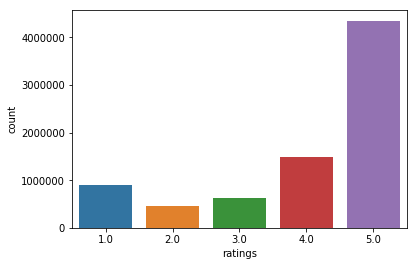

In [3]:
sns.countplot(x='ratings', data=dataset)

dataset is not equally distributed in ratings, dataset more 5 ratings and less 2 ratings

# Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [4]:
df_cnt = dataset['userId'].value_counts()

In [5]:
dataset_user_gt50 = dataset[dataset['userId'].isin(df_cnt[df_cnt >= 50].index)]
dataset_user_gt50.head()

,userId,productId,ratings,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200


In [6]:
dataset_user_gt50.shape

(125871, 4)

# Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset_user_gt50, test_size=0.30, random_state=1)

In [8]:
df_train.shape

(88109, 4)

In [9]:
df_test.shape

(37762, 4)

# Build Popularity Recommender model.

In [10]:
ratings_mean_count = pd.DataFrame(dataset_user_gt50.groupby('productId')['ratings'].mean()) 
ratings_mean_count['rating_counts'] = pd.DataFrame(dataset_user_gt50.groupby('productId')['ratings'].count())
ratings_mean_count.sort_values(by='ratings', ascending=False, inplace=True)
ratings_mean_count.head(10)

,ratings,rating_counts
productId,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2
B003RFHFJE,5.0,1
B003RF6H66,5.0,1
B003RDN2V6,5.0,1
B003RCI4OW,5.0,1


# Build Collaborative Filtering model.

In [12]:
from surprise import KNNWithMeans
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [13]:
dataset = Dataset.load_from_df(df_train[['userId', 'productId', 'ratings']], Reader(rating_scale=(1,5)))
df_train, df_test = train_test_split(dataset, test_size=0.30)

In [29]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
predictions = algo.fit(df_train).test(df_test)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
predictions

[Prediction(uid='A2NOW4U7W3F7RI', iid='B00746W3HG', r_ui=5.0, est=4.7265625, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A10X9ME6R66JDX', iid='B00009YUPC', r_ui=4.0, est=4.264024904338803, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A31RZMVAFMLB8B', iid='B005Q65JHM', r_ui=5.0, est=4.285714285714286, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3CG93783LP0FO', iid='B003WVFAO0', r_ui=2.0, est=4.2, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2MJ8OL2FYN7CW', iid='B004YIZXEC', r_ui=4.0, est=4.3, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A33PVCHCQ2BTN0', iid='B00E87E1OM', r_ui=5.0, est=4.535714285714286, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5KMMY627T3W', iid='B00005LENO', r_ui=5.0, est=4.533333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3RR2P5IS3DGPR', iid='B00E87E1OM', r_ui=5.0,

# Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [31]:
accuracy.rmse(predictions)

RMSE: 1.0408


1.0408021498700324

Since Popularity based recommendation doesnt have any prediction or model, we cannot calculate RMSE for it

# Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [32]:
def get_Iu(uid):

    try:
        return len(df_train.ur[df_train.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    
    try:
        return len(df_train.ir[df_train.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

In [33]:
prediction_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
prediction_df['Iu'] = prediction_df.uid.apply(get_Iu)
prediction_df['Ui'] = prediction_df.iid.apply(get_Ui)
prediction_df['err'] = abs(prediction_df.est - prediction_df.rui)

In [34]:
best_predictions = prediction_df.sort_values(by=['uid','err'])[:10]
best_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
7456,A100UD67AHFODS,B004I5BUSO,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",57,13,0.000000
251,A100UD67AHFODS,B002NU5S02,4.0,4.264025,"{'was_impossible': True, 'reason': 'User and/o...",57,0,0.264025
17868,A100UD67AHFODS,B003VS6YJO,4.0,4.264025,"{'was_impossible': True, 'reason': 'User and/o...",57,0,0.264025
3201,A100UD67AHFODS,B000HZDF8W,5.0,4.526316,"{'actual_k': 0, 'was_impossible': False}",57,9,0.473684
3548,A100UD67AHFODS,B004YI9NTS,5.0,4.526316,"{'actual_k': 0, 'was_impossible': False}",57,4,0.473684


# Summarise your insights.

Summary:

1. We can use popularity mased RS to recomend items to the user 
2. RMSE of Item-Item is 1.33 , RMSE of User-User is 1.0, hence User-User RS is much better